<a href="https://colab.research.google.com/github/guhang987/federated-learning/blob/master/%E5%9F%BA%E4%BA%8ETFF%E7%9A%84FedAvg%E7%AE%97%E6%B3%95%E7%9A%84%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

本实验根据[TensorFlow Federated（TFF）官方教程](https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_2)以及提出了FederatedAveragin（FedAvg）算法的论文《Communication-Efficient Learning of Deep Networks from Decentralized Data》模拟实现了FedAvg算法。

## 配置环境

In [ ]:
!pip install --quiet --upgrade tensorflow_federated
%load_ext tensorboard

     |████████████████████████████████| 460kB 3.5MB/s 
     |████████████████████████████████| 174kB 11.0MB/s 
     |████████████████████████████████| 296kB 16.3MB/s 
     |████████████████████████████████| 92kB 8.4MB/s 
     |████████████████████████████████| 1.0MB 17.8MB/s 


In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

# TODO(b/148678573,b/148685415): must use the ReferenceExecutor because it
# supports unbounded references and tff.sequence_* intrinsics.
tff.framework.set_default_executor(tff.test.ReferenceExecutor())

In [ ]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

'Hello, World!'

## 准备联邦数据集

说明：
`@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)`标注的代码包含了服务器端和客户端的操作，是一种抽象。在实际开发中应自己实现


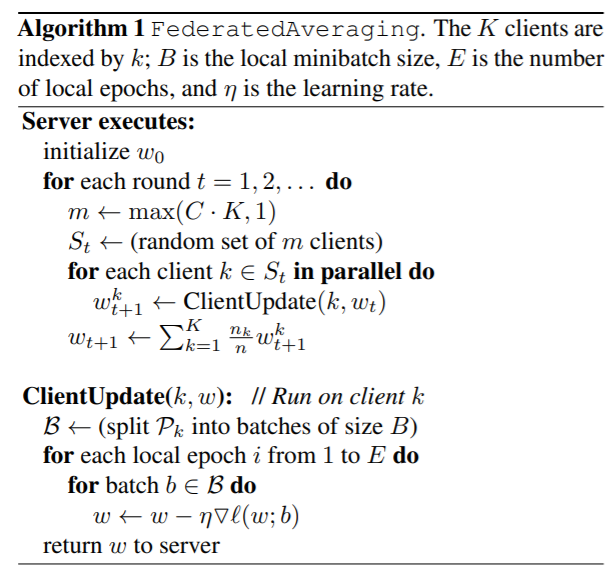

In [ ]:
#下载mnist数据集
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()
[(x.dtype, x.shape) for x in mnist_train]

11493376/11490434 [==============================] - 0s 0us/step


[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

对于每个用户的样本，根据BATCH_SIZE将其分割为大小固定的批次。BATCH_SIZE*批数=样本总数。

- BATCH_SIZE=1即在线学习
- BATCH_SIZE很小，那么每批训练得到的梯度各不相同，各自为政，导致最终很难收敛
- BATCH_SIZE适中，即批梯度下降法（Mini-batches Learning）。因为如果数据集足够充分，那么用一半（甚至少得多）的数据训练算出来的梯度与用全部数据训练出来的梯度是几乎一样的。本实验BATCH_SIZE=200
- BATCH_SIZE很大，虽然充分利用了内存，但每次训练对参数的修正很慢，方向几乎固定
- BATCH_SIZE最大不能大于内存

另外，**为了模拟non-IID，用minst数据集中每个数字对应的图片（如标签为5的所有手写图片）模拟了一个设备中的本地数据**。

In [ ]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 200
#BATCHES不为整数时如何处理？
BATCHES = int(NUM_EXAMPLES_PER_USER/BATCH_SIZE)
#NUM_EXAMPLES_PER_USER/BATCH_SIZE=5,即每个设备有5批数据
#该函数实现了选出source中标签=digit的全部图片并处理
#【FedAVG@C】split 设备总样本 into batches of size BATCH_SIZE
def get_data_for_digit(source, digit):
  output_sequence = []
  #记录标签列表中，等于指定digit的元素对应的序号
  #例如标签列表是[4,5,6,5,1],指定digit=5，那么all_sample=[1，3]
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  #以下for循环实现了对all_sample数组中所有指针指向的图片的处理
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    #每次按顺序选取BATCH_SIZE张
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            #归一化
            np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([source[1][i] for i in batch_samples], dtype=np.int32)
    })
  #output_sequence是用户数据的列表，而用户数据又是批数据的列表
  return output_sequence

#根据手写数字1~10的标签来分割为10个数据集，代表了10个设备中的non-IID的数据
federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]
federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]


为了验证上述预处理是否正确，可以查看标签为5(也就是第5个设备）的数据集中的倒数第一批数据，它的x是像素图片，y是标签

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


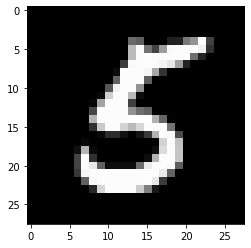

In [ ]:
print(federated_train_data[5][-1]['y'])

from matplotlib import pyplot as plt
plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.grid(False)
plt.show()

## 定义一个损失函数

TFF是强类型的，参数必须定义好类型。由于最后一批数据的大小不一定是BATCH_SIZE，我们将每批的容量设置为`None`

In [ ]:
#定义一个抽象的TFF类型规范
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)

str(MODEL_TYPE)

'<weights=float32[784,10],bias=float32[10]>'

下面我们开始定义前向传播函数

In [ ]:
# NOTE: `forward_pass` is defined separately from `batch_loss` so that it can 
# be later called from within another tf.function. Necessary because a
# @tf.function  decorated method cannot invoke a @tff.tf_computation.

@tf.function
def forward_pass(model, batch):
  #定义一个两层的神经网络（2NN）
  predicted_y = tf.nn.softmax(
      tf.matmul(batch['x'], model['weights']) + model['bias'])
  predictions = tf.cast(tf.argmax(predicted_y, 1), tf.int32)
  #print(predictions)=[0,...,0]
  flat_labels = tf.reshape(batch['y'], [-1])
  #print(batch['y'])=[5,...,5]
  loss = -tf.reduce_mean(
      tf.reduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, batch['y']), tf.float32))
  #print(accuracy)
  return loss, accuracy
  '''
  return -tf.reduce_mean(
      tf.reduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))
  '''
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)



现在将权重w和偏置值b都设置为0，简单测试下上述代码是否正确，同时初始化initial_model作为后续联邦训练的输入。

In [ ]:
#【FedAVG@S】initialize w
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))
#选取标签为5的所有图片作为样例
sample_batch = federated_train_data[5][-1]
batch_loss(initial_model, sample_batch)

(2.3025854, 0.0)

分析：batch_loss函数也就是forward_pass函数接收了两个参数：模型和样本，模型的w和b在函数内被接收，再加上样本的x，计算出y和损失函数的值`2.3025854`。

损失函数是模型（w和b）的函数，为了求w和b为何值时损失函数最小：$$w^*=argmin L(w,b)$$可以使用梯度下降算法。

## 在单批数据上使用梯度下降

In [ ]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`. Must
  # be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from `batch_loss`.
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    #求出梯度
    grads = tape.gradient(loss, model_vars)
    #反向传播: model_vars=model_vars-learning_rate*grads
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    #返回新的梯度到batch_train，再到batch_fn，再到local_train，
    #再到locally_trained_model，再到local_eval中结合数据来计算损失函数
    return model_vars

  return _train_on_batch(model_vars, batch)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#训练5次来测试上述代码
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))
print(losses)

[(0.21017574, 1.0), (0.13879976, 1.0), (0.105693415, 1.0), (0.085996725, 1.0), (0.07277652, 1.0)]


以上输出说明在单批数据上，多次梯度下降是有效果的。接下来需要在若干批数据也就是设备中的全部本地数据使用梯度下降。

## 在所有本地数据上（若干批）使用梯度下降

In [ ]:
EPOCH = 10
#将对设备所有数据的训练分割为 对设备中每批数据的训练
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)
print(LOCAL_DATA_TYPE)
@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
#对每批样本，依次使用batch_train更新参数，直到覆盖所有样本
def local_train(initial_model, learning_rate, all_batches):
  @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
  def batch_fn(model, batch):
    return batch_train(model, batch, learning_rate)
  
  model = tff.sequence_reduce(all_batches, initial_model, batch_fn)
  #【FedAVG@C】for each local epoch i from 1 to EPOCH do
  for _ in range(EPOCH-1):
    #【FedAVG@C】for batch b∈B do w <- w-learning_rate*g
    model = tff.sequence_reduce(all_batches, model, batch_fn)
  #【FedAVG@C】return w to server
  return model

<x=float32[?,784],y=int32[?]>*


接下来进行本地训练


In [ ]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

## 本地评估

本地评估的方法是：对所有批次数据，每批执行batch_loss计算损失值、准确率，将其**加在一起（不是取平均值）**得到本地损失值与准确率。这里TODO注释的意思应该是TFF官方还没有写出来tff.sequence_average()方法，所以只能用sum。那么我后面将accuracy除以批数即可得平均值。

In [ ]:

@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
  #all_batches指标签为5的所有图片，最多1000张，每批BATCH_SIZE张，BATCHES批
  # TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.
  return tff.sequence_sum(
      #对每批数据求损失以及准确率，再连加
      tff.sequence_map(
          tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),
          all_batches))

In [ ]:
initial_model_loss,initial_model_accuracy=local_eval(initial_model,federated_train_data[5])

local_model_loss,local_model_accuracy=local_eval(locally_trained_model, federated_train_data[5])

print('initial_model loss ={} ,accuracy={}'.format(
    initial_model_loss,initial_model_accuracy/BATCHES))
print('locally_trained_model loss ={},accuracy={}'.format(
    local_model_loss,local_model_accuracy/BATCHES))

initial_model loss =11.512927055358887 ,accuracy=0.0
locally_trained_model loss =0.05232632905244827,accuracy=1.0


分析结果：
1. 使用本设备的数据集federated_train_data[5]来评估时的数据：
  - Epoch=1 loss=0.3815，accuracy=1.0
  - Epoch=5 loss=0.0973，accuracy=1.0
  - Epoch=10 loss=0.0523，accuracy=1.0

  说明本地训练的轮次越多，效果越好

2. 使用别的设备的数据集`federated_train_data[6]`来评估时，可以发现准确率很低，这是因为：

  最开始我们为了模拟数据的non-IID，假设10个用户每人手写1~10这10个不同的数字。然后我们用第5个用户的数据训练模型，成功识别出了数字5，然而面对数字6则无法识别。所以应在全局视角下使用联邦评估，评估整个系统的模型的损失和准确率。

## 联邦评估

In [ ]:
#定义联邦类型
#MODEL_TYPE: <weights=float32[784,10],bias=float32[10]>
SERVER_MODEL_TYPE = tff.FederatedType(MODEL_TYPE, tff.SERVER)
#LOCAL_DATA_TYPE: <x=float32[?,784],y=int32[?]>*
CLIENT_DATA_TYPE = tff.FederatedType(LOCAL_DATA_TYPE, tff.CLIENTS)


联邦评估的步骤是：将模型分发给各个设备，让每个设备计算自己所有批数据的损失函数，并回传，再取平均值

In [ ]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_mean(
      #让每个客户端执行local_eval方法
      tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))


`tff.federated_broadcast(model)`指将模型参数分发给参与训练的设备，在本实验中是一种抽象的表示，所以在实际的分布式系统中需要自己实现这个方法。

In [ ]:
print('initial_model loss =', federated_eval(initial_model,
                                             federated_train_data))
print('locally_trained_model loss =',
      federated_eval(locally_trained_model, federated_train_data))

initial_model loss = <11.512926,0.5>
locally_trained_model loss = <35.812584,0.5>


可以看出使用**一个设备**训练出的模型来评估系统中所有设备中的数据，准确率也不高。接下来我们需要使用联邦训练，让**所有设备开始训练**。
## 【核心】联邦训练

联邦训练的步骤是，使用`federated_map()`方法，服务器将参数和学习率广播到每个参与者的设备上，每个参与者使用`local_train()`开始本地训练。本地训练完毕后，会返回训练完的模型（w和b）给服务器，服务器使用`federated_mean()`方法取加权平均值，得到了本轮系统训练结束后的模型。

In [ ]:
SERVER_FLOAT_TYPE = tff.FederatedType(tf.float32, tff.SERVER)

@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE, CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))

回顾下本次实验参数的设定值
- 模型参数（w、b）初始值：0
- 本地学习率：
初始0.1之后每轮*0.9
- 系统轮次：
100
- 本地轮次（EPOCH、E）：
5
- 设备总数：
10
- 每轮选择设备数：
10（全部，C=1）
- BATCH_SIZE(B)：
200
- 每个设备拥有的样本数（nk）：
1000
- 数据分布：
non-IID

开始进行100轮的联邦训练：

In [ ]:
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)

#最初模型的w和b都是0
model = initial_model
learning_rate = 0.1
with summary_writer.as_default():
  for round_num in range(50):
    model = federated_train(model, learning_rate, federated_train_data)
    learning_rate = learning_rate * 0.9
    loss,accuracy = federated_eval(model, federated_train_data)
    print('round {}, loss={},accuarcy={}'.format(round_num, loss,accuracy/BATCHES))
    tf.summary.scalar('loss', loss, step=round_num)
    tf.summary.scalar('accuracy', accuracy/BATCHES, step=round_num) 

round 0, loss=10.643875122070312,accuarcy=0.6812000274658203
round 1, loss=9.886220932006836,accuarcy=0.7333000183105469
round 2, loss=9.223746299743652,accuarcy=0.7595000267028809
round 3, loss=8.645051956176758,accuarcy=0.7732000827789307
round 4, loss=8.139508247375488,accuarcy=0.7823999881744385
round 5, loss=7.697207450866699,accuarcy=0.7903000831604003
round 6, loss=7.309234619140625,accuarcy=0.79660005569458
round 7, loss=6.967775821685791,accuarcy=0.8027999877929688
round 8, loss=6.666112422943115,accuarcy=0.8083000183105469
round 9, loss=6.398534297943115,accuarcy=0.8115999221801757
round 10, loss=6.160220146179199,accuarcy=0.8152999877929688
round 11, loss=5.947114944458008,accuarcy=0.8187000274658203
round 12, loss=5.755807876586914,accuarcy=0.8229000091552734
round 13, loss=5.583432197570801,accuarcy=0.8253999710083008
round 14, loss=5.427569389343262,accuarcy=0.828700065612793
round 15, loss=5.286177635192871,accuarcy=0.8323999404907226
round 16, loss=5.157526969909668,acc

In [ ]:

%tensorboard --logdir /tmp/logs/scalars/ --port=0


<IPython.core.display.Javascript object>

In [ ]:

# Run this this cell to clean your directory of old output for future graphs from this directory.
!rm -R /tmp/logs/scalars/*

使用测试集评估

In [ ]:
'''
print('initial_model test loss =',
      federated_eval(initial_model, federated_test_data))
print('trained_model test loss =', federated_eval(model, federated_test_data))
'''
initial_model_loss,initial_model_accuracy=federated_eval(initial_model, federated_test_data)
local_model_loss,local_model_accuracy=federated_eval(model, federated_test_data)

print('initial_model test loss ={} ,accuracy={}'.format(
    initial_model_loss,initial_model_accuracy/BATCHES))
print('locally_trained_model test loss ={},accuracy={}'.format(
    local_model_loss,local_model_accuracy/BATCHES))

initial_model test loss = <11.512926,0.5>
trained_model test loss = <5.610701,4.1564684>


## 总结
本次实验是模拟实验，在一个机器上模拟了联邦学习，实现了Federated averaging算法。
需要继续改进的地方：
1. 模型：本次实验使用2层的DNN网络实现图像分类，下一个实验需要使用LSTM进行文本生成，考虑模型对联邦学习的影响。
2. C=1，即选择了全部可用设备参与训练，未考虑设备选择问题。
3. 假设每个设备的数据量相同，未考虑数据量不均衡的问题
3. 准确率不高。100轮的准确率只达到了85.56%。但论文《Communication-Efficient Learning of Deep Networks from Decentralized Data》的实验数据表明BATCHSIZE=10、其他条件基本相同情况下需要380轮达到97%的准确率。如何调整模型及其参数来提高准确率、减少轮次是一个重要的问题
4. 需要在实际情况下部署这个分布式系统，考虑到通信时间，进行一次在移动设备上的真实的实验